In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

In [23]:
# --- Load original dataset ---
df = pd.read_csv(r"D:\Project DS Final\2025\check\final_clean_data.csv")

# --- Select features for classification ---
selected_columns = [
    "MONTH","DAY_OF_MONTH","DAY_OF_WEEK",
    "OP_UNIQUE_CARRIER","ORIGIN","DEST",
    "CRS_DEP_TIME","CRS_ARR_TIME",
    "CRS_ELAPSED_TIME","DISTANCE",
    "HourlyDewPointTemperature","HourlyDryBulbTemperature",
    "HourlyRelativeHumidity","HourlyVisibility","HourlyWindSpeed",
    "DEP_DEL15"
]
df_classifi = df[selected_columns].copy()
print("✅ Dataset loaded. Shape:", df_classifi.shape)

✅ Dataset loaded. Shape: (50029, 16)


In [24]:
# ===============================
# 2️⃣ Encode categorical columns
# ===============================
from sklearn.preprocessing import LabelEncoder

label_cols = ["OP_UNIQUE_CARRIER", "ORIGIN", "DEST"]
le = LabelEncoder()

for col in label_cols:
    df_classifi[col] = le.fit_transform(df_classifi[col])

print("🔤 Label encoding completed for:", label_cols)
print("Preview:")
display(df_classifi.head())

🔤 Label encoding completed for: ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
Preview:


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,DEP_DEL15
0,4,1,2,0,1,62,6.53,9.33,168.0,1020.0,33.0,36.0,89.0,5.0,10.0,0.0
1,4,1,2,0,1,62,15.45,18.12,160.0,1020.0,33.0,45.0,63.0,10.0,10.0,1.0
2,4,1,2,0,4,14,7.33,15.32,299.0,2279.0,37.0,43.0,80.0,10.0,6.0,0.0
3,4,1,2,0,4,14,13.83,21.83,300.0,2279.0,41.0,49.0,74.0,10.0,6.0,0.0
4,4,1,2,0,4,14,22.00,6.00,300.0,2279.0,41.0,45.0,86.0,10.0,7.0,0.0


In [25]:
# ===============================
# 3️⃣ Scale toàn bộ dataset (data leakage intentionally)
# ===============================
scale_cols = [
    "CRS_DEP_TIME","CRS_ARR_TIME","CRS_ELAPSED_TIME","DISTANCE",
    "HourlyDewPointTemperature","HourlyDryBulbTemperature",
    "HourlyRelativeHumidity","HourlyVisibility","HourlyWindSpeed"
]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_classifi[scale_cols])
df_classifi[scale_cols] = scaled

print("📏 Scaled entire dataset (not just train/test).")


📏 Scaled entire dataset (not just train/test).


In [26]:
# ===============================
# 4️⃣ Apply SMOTE on the entire dataset (data leakage style)
# ===============================
X = df_classifi.drop("DEP_DEL15", axis=1)
y = df_classifi["DEP_DEL15"]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

df_classifi = pd.concat(
    [pd.DataFrame(X_res, columns=X.columns), y_res.reset_index(drop=True)],
    axis=1
)

print("⚙️ SMOTE applied on full dataset (data leakage).")
print("New shape after resampling:", df_classifi.shape)
print("Class distribution:\n", y_res.value_counts(normalize=True))


⚙️ SMOTE applied on full dataset (data leakage).
New shape after resampling: (79706, 16)
Class distribution:
 DEP_DEL15
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [27]:
# ===============================
# 5️⃣ Handle Outliers (Clipping) on entire dataset
# ===============================
num_cols = [
    "CRS_DEP_TIME","CRS_ARR_TIME","CRS_ELAPSED_TIME","DISTANCE",
    "HourlyDewPointTemperature","HourlyDryBulbTemperature",
    "HourlyRelativeHumidity","HourlyVisibility","HourlyWindSpeed"
]

for col in num_cols:
    Q1 = df_classifi[col].quantile(0.25)
    Q3 = df_classifi[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.75 * IQR   # dùng 1.75 thay vì 1.5 để clip nhẹ hơn
    upper = Q3 + 1.75 * IQR
    df_classifi[col] = df_classifi[col].clip(lower, upper)

print("✂️ Outlier clipping done (applied to full dataset).")


✂️ Outlier clipping done (applied to full dataset).


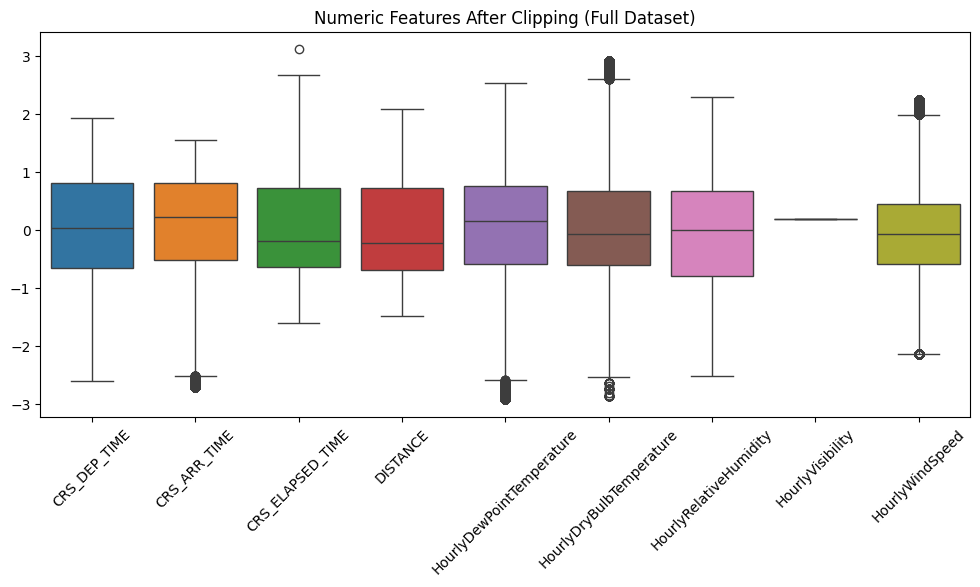

In [28]:
# ===============================
# 6️⃣ Visualize Boxplot After Clipping
# ===============================
plt.figure(figsize=(12,5))
sns.boxplot(data=df_classifi[num_cols])
plt.title("Numeric Features After Clipping (Full Dataset)")
plt.xticks(rotation=45)
plt.show()


In [29]:
df_classifi.to_csv(r"D:\Project DS Final\Data\classi_mod_data.csv", index=False)